In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import json
import multiprocessing

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 1000)

# define train or test
df_type = 'train'

ModuleNotFoundError: No module named 'fastai.structured'

# First Work

In [2]:
types = {'fullVisitorId': 'str'}

In [3]:
cols_to_parse = ['device', 'geoNetwork', 'totals', 'trafficSource']

In [4]:
# Load csv
df = pd.DataFrame()
for chunk in pd.read_csv(df_type + '_v2.csv',
                         iterator=True,
                         parse_dates=['visitStartTime'],
                         dtype=types,
                         converters={column: json.loads for column in cols_to_parse},
                         chunksize=10 ** 6,
                         nrows=50000):
    chunk.drop(['hits', 'customDimensions'], axis=1, inplace=True)
    df = pd.concat([df, chunk])
    del chunk

In [ ]:
# df.to_csv('train_v2_clean.csv', index=False)

In [ ]:
# df = pd.read_csv('train_v2_clean.csv',
#                  parse_dates=['visitStartTime'], 
#                  dtype=types
#                 )

In [5]:
def dict_to_col(ctp=cols_to_parse, df=df, str_rmv=['not available in demo dataset', '(not set)', '(not provided)']):
    for each in ctp:
#         series = df[each].map(eval).apply(pd.Series)
        series = df[each].apply(pd.Series)
        for strings in str_rmv:
            series = series.replace({strings: None})
        series.dropna(axis='columns', how='all', inplace=True)
        print(each, 'done')
        df = df.drop(columns=[each]).join(series)
        del series
    return df

In [8]:
# Was a good try!
def multi_dict_to_col(each, df=df, str_rmv=['not available in demo dataset', '(not set)', '(not provided)']):
    series = df[each].apply(pd.Series)
    for strings in str_rmv:
        series = series.replace({strings: None})
    series.dropna(axis='columns', how='all', inplace=True)
    print(each, 'done')
    return series
# df = df.join(multiprocessing.Pool().map(multi_dict_to_col, cols_to_parse))

In [6]:
df = dict_to_col()
# df.drop(columns=cols_to_parse, inplace=True)
df.drop(columns=['adwordsClickInfo'], inplace=True)

device done
geoNetwork done
totals done
trafficSource done


In [ ]:
os.makedirs('tmp', exist_ok=True)
# df.to_feather('tmp/1' + df_type)

In [5]:
df = pd.read_feather('tmp/1' + df_type)

/home/fsx/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [ ]:
def rm_datepart(df, column_name, reconstruct=True):
    '''Reverts add_datepart
    column_name -> 
    '''
    columns=['Year',
             'Month',
             'Week',
             'Day',
             'Dayofweek',
             'Dayofyear',
             'Is_month_end',
             'Is_month_start',
             'Is_quarter_end',
             'Is_quarter_start',
             'Is_year_end',
             'Is_year_start',
             'Hour',
             'Minute',
             'Second',
             'Elapsed'
            ]
    original = column_name
    column_name = re.sub('[Dd]ate$', '', column_name)
    if reconstruct: df[original] = pd.to_datetime(df[str(column_name+'Elapsed')], unit='s')
    for col in columns:
        if str(column_name+col) in df: df.drop(columns=[str(column_name+col)], inplace=True)
    return
# Do function that reverts add_datepart

In [7]:
df.fillna(value=np.nan, inplace=True)
df.keyword.replace('(not provided)', np.nan, inplace=True)
df.keyword = df.keyword.str.encode('utf_8', errors='ignore').str.decode('utf_8')
df.networkDomain.replace('unknown.unknown', np.nan, inplace=True)
df.replace('(not set)', np.nan, inplace=True)
df['visitStartTime'] = pd.to_datetime(df.visitStartTime, unit='s')
add_datepart(df, 'visitStartTime', time=True)
df.channelGrouping.replace('(Other)', None, inplace=True)
df.medium.replace('(none)', None, inplace=True)
df.totalTransactionRevenue = df.totalTransactionRevenue.fillna(0).astype(int)
df.transactions = df.transactions.fillna(0).astype(int)

In [8]:
df.to_feather('tmp/2' + df_type)

In [9]:
df = pd.read_feather('tmp/2' + df_type)

/home/fsx/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [10]:
df['campaign'] = df.campaign.notnull()
df['bounces'] = df.bounces.notnull()
df['newVisits'] = df.newVisits.notnull()
df['referralPath'] = df.referralPath.notnull()
df['isTrueDirect'] = df.isTrueDirect.notnull()
df['adContent'] = df.adContent.notnull().astype(bool)

In [11]:
df.to_feather('tmp/3' + df_type)

In [17]:
df = pd.read_feather('tmp/3' + df_type)

/home/fsx/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [18]:
columns = ['browser', 'operatingSystem']
for col in columns:
    cutoff = df[col].value_counts() < 1000
    cutoff = cutoff[cutoff]
    cutoff = cutoff.reset_index()['index']

    for i in cutoff:
        df.loc[df[col] == i, col] = 'Other'

In [19]:
df.to_feather('tmp/4' + df_type)

In [20]:
df = pd.read_feather('tmp/4' + df_type)

/home/fsx/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [21]:
df['hits'] = df.hits.astype(int)
df.pageviews.fillna(0, inplace=True)
# df['pageviews'] = df.pageviews.astype(str).astype(int)
df['pageviews'] = df.pageviews.astype(float)

In [22]:
df.drop(columns=[
    'date',
    'visitStartTimeMinute',
    'visitStartTimeSecond',
    'socialEngagementType',
    'medium',
    'visitId',
    'visits',
    'transactionRevenue',
    'deviceCategory',
    'continent',
    'subContinent',
    'networkDomain',
    'source'
], inplace=True)

In [23]:
df.head()

,channelGrouping,fullVisitorId,visitNumber,browser,operatingSystem,isMobile,deviceCategory,continent,subContinent,country,region,metro,city,networkDomain,hits,pageviews,bounces,newVisits,sessionQualityDim,timeOnSite,transactions,totalTransactionRevenue,campaign,source,keyword,referralPath,isTrueDirect,adContent,visitStartTimeYear,visitStartTimeMonth,visitStartTimeWeek,visitStartTimeDay,visitStartTimeDayofweek,visitStartTimeDayofyear,visitStartTimeIs_month_end,visitStartTimeIs_month_start,visitStartTimeIs_quarter_end,visitStartTimeIs_quarter_start,visitStartTimeIs_year_end,visitStartTimeIs_year_start,visitStartTimeHour,visitStartTimeElapsed
0,Organic Search,3162355547410993243,1,Firefox,Windows,False,desktop,Europe,Western Europe,Germany,None,None,None,None,1,1.0,True,True,1,None,0,0,False,google,water bottle,False,False,False,2017,10,42,17,1,290,False,False,False,False,False,False,0,1508198450
1,Referral,8934116514970143966,6,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,None,2,2.0,False,False,2,28,0,0,False,sites.google.com,None,True,False,False,2017,10,42,16,0,289,False,False,False,False,False,False,17,1508176307
2,Direct,7992466427990357681,1,Chrome,Android,True,mobile,Americas,Northern America,United States,None,None,None,windjammercable.net,2,2.0,False,True,1,38,0,0,False,(direct),None,False,True,False,2017,10,42,17,1,290,False,False,False,False,False,False,0,1508201613
3,Organic Search,9075655783635761930,1,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,None,None,None,None,2,2.0,False,True,1,1,0,0,False,google,None,False,False,False,2017,10,42,16,0,289,False,False,False,False,False,False,16,1508169851
4,Organic Search,6960673291025684308,1,Chrome,Windows,False,desktop,Americas,Central America,Mexico,None,None,None,prod-infinitum.com.mx,2,2.0,False,True,1,52,0,0,False,google,None,False,False,False,2017,10,42,16,0,289,False,False,False,False,False,False,21,1508190552


In [24]:
df.to_feather('tmp/5' + df_type)

# EDA

In [25]:
df_type = 'train'

In [48]:
df = pd.read_feather('tmp/5' + df_type)

/home/fsx/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [49]:
df = df.sort_values('visitStartTimeElapsed').reset_index(drop=True)

In [50]:
columns = ['hits', 'pageviews', 'totalTransactionRevenue', 'transactions']
# if df_type == 'train': columns.append('transactionRevenue')
for col in columns:
    _sum = str(col) + '_sum'
    df[_sum] = df.groupby('fullVisitorId')[col].transform(pd.Series.cumsum)

In [51]:
df.totalTransactionRevenue.fillna(value=0.0, inplace=True)
df.totalTransactionRevenue = np.log1p(df.totalTransactionRevenue.astype(float))
df.totalTransactionRevenue_sum.fillna(value=0.0, inplace=True)
df.totalTransactionRevenue_sum = np.log1p(df.totalTransactionRevenue_sum.astype(float))

In [52]:
type_customer_mean = df.totalTransactionRevenue_sum.groupby(df.fullVisitorId).max()
type_customer_mean = type_customer_mean[type_customer_mean > 0].mean()
type_customer_whale = type_customer_mean * 1.5
df['type_customer'] = pd.cut(df.totalTransactionRevenue_sum,
                             bins=[0.0, 0.0001, type_customer_whale, 1000000],
                             include_lowest=True,
                             labels=['first_timer', 'returning', 'whale'])

In [53]:
df.type_customer = df.type_customer.cat.add_categories(['lookers'])
df.type_customer[(df.visitNumber > 1) & (df.type_customer == 'first_timer')] = 'lookers'

In [54]:
df_train = df.copy()

In [55]:
# subset = df_train.sample(frac=0.85)
# subset.totalTransactionRevenue = 35050
# df_train.update(subset)
# df_train.totalTransactionRevenue.replace(35050, np.nan, inplace=True)
# df_train.loc[:, 'type_customer'][df_train.totalTransactionRevenue.isnull()] = np.nan

In [56]:
df.to_feather('tmp/5.5' + df_type)

In [57]:
df_type = 'train'

In [68]:
df = pd.read_feather('tmp/5.5' + df_type)

/home/fsx/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [69]:
df = df.sample(frac=1).reset_index(drop=True)

In [70]:
fullVis = df.fullVisitorId
df.drop(columns=['fullVisitorId', 'visitStartTimeElapsed', 'transactions'], inplace=True)

# Train

In [71]:
train_cats(df)

In [72]:
# if df_type == 'test':
#     df['transactionRevenue'] = 0.0
df1, y, nas = proc_df(df, 'totalTransactionRevenue', max_n_cat=5)
# if df_type == 'test': df1['operatingSystem_Windows Phone'] = 0

In [73]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

# For train set
if df_type == 'train':
    n_valid = 0.7
    n_trn = int(len(df1)*n_valid)
    raw_train, raw_valid = split_vals(df, n_trn)
    X_train, X_valid = split_vals(df1, n_trn)
    y_train, y_valid = split_vals(y, n_trn)

    X_train.shape, y_train.shape, X_valid.shape

In [74]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [75]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=50, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.48236564061098036, 0.4135320755257812, 0.9225498178710766, 0.9437375790553065, 0.9197648418204123]


In [ ]:
# Train
df1.columns

# Submit

In [ ]:
if df_type == 'test':
    PredictedLogRevenue = m.predict(df1)
#     submissions = pd.DataFrame(df['fullVisitorId'].str[3:])
    submissions = pd.DataFrame(fullVis.str[3:])
    submissions['PredictedLogRevenue'] = np.expm1(PredictedLogRevenue)
    grouped = np.log1p(submissions.groupby('fullVisitorId').sum()).reset_index()
    filename = 'submission_' + str(time.time()) + '.csv'
    grouped.to_csv(filename, index=False)
    print(filename)
    
    submissions = pd.DataFrame(fullVis.str[3:])
    submissions['PredictedLogRevenue'] = PredictedLogRevenue
    grouped = submissions.groupby('fullVisitorId').sum().reset_index()
    filename = 'submission_' + str(time.time()) + '.csv'
    grouped.to_csv(filename, index=False)
    print(filename)

In [ ]:
if df_type == 'test':
#     !kaggle competitions submit -c ga-customer-revenue-prediction -f 'submission_1541472945.9338593.csv' -m "Log of Sum"
#     !kaggle competitions submit -c ga-customer-revenue-prediction -f 'submission_1541472139.7219512.csv' -m "Sum of Log"

# Analysis

In [76]:
def plot_fi(m, df1, n_feat):
    return rf_feat_importance(m, df1)[:n_feat].plot('cols', 'imp', 'barh', figsize=(15,20), legend=False)

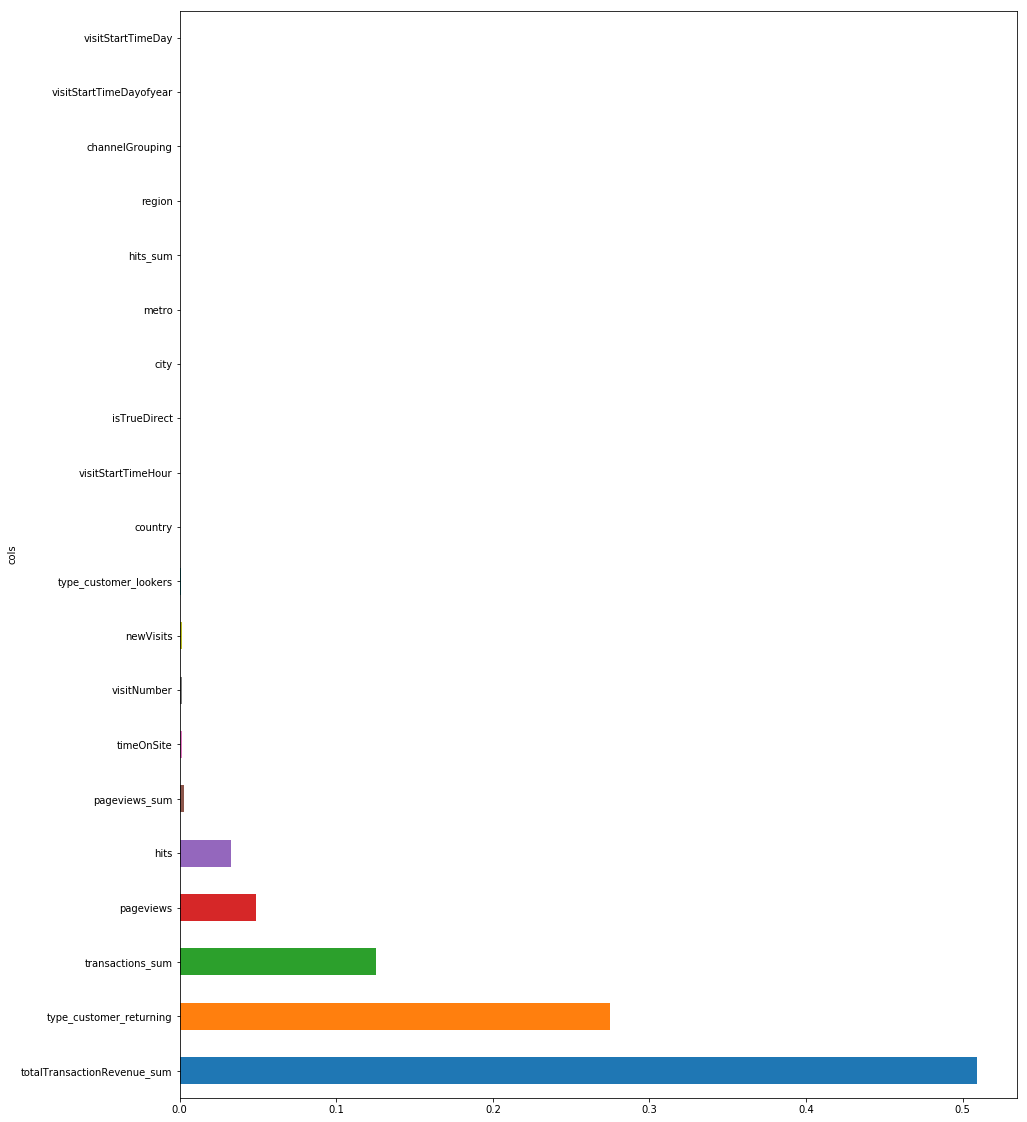

In [77]:
plot_fi(m, df1, 20);

In [ ]:
keep = rf_feat_importance(m, df1)[:30]
keep = list(keep.cols)
# keep.append('transactionRevenue')
df1 = df1[keep]
keep

In [ ]:
to_test = ['hits', 'pageviews', 'visitStartTimeMonth', 'visitStartTimeWeek',
       'visitStartTimeDay', 'visitStartTimeDayofweek',
       'visitStartTimeDayofyear', 'visitStartTimeHour']

for each in to_test:
    fields = [each, 'transactionRevenue']
    summary = df[fields].groupby(each, as_index=True).mean()
    summary.plot(figsize=(10,4), title=each);
    summary = df[fields].groupby(each, as_index=True).sum()
    summary.plot(figsize=(10,4));